In [1]:
import time
import math
import numpy as np
from problems import sixth_order
from pinn import Seg_PINN
from plots_and_stats import plot_errors, plot_comparison
np.random.seed(1234)

a1 = 1.000, a2 = -1.000, a3 = -2.800, a4 = -0.300, a5 = -0.600, a6 = 0.100,
 b1 = 6.000, b2 = -1.525, b3 = 0.113


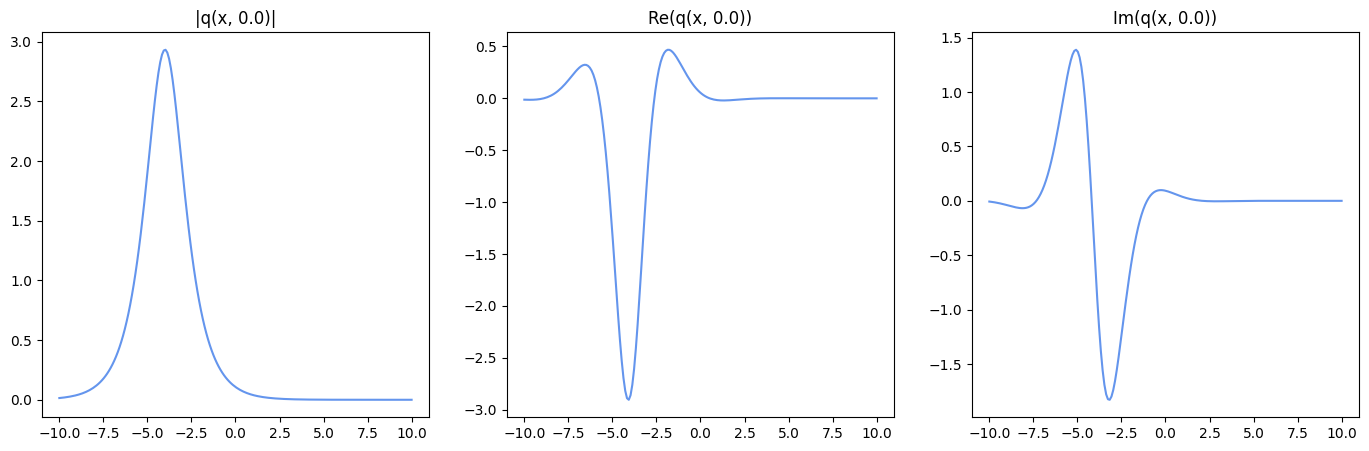

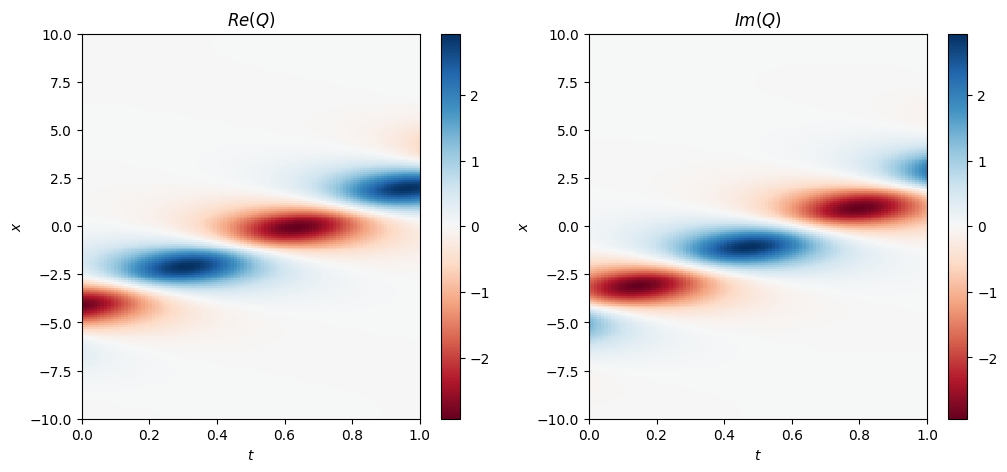

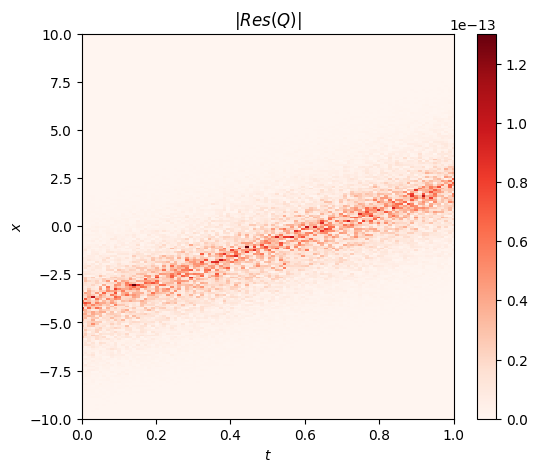

In [2]:
#domain setting
x_0=-10.
x_1=10.
t_0=0.
t_1=1.
#problem setting
a1 = 1
a2 = -1
a4 = -0.3
a6 = 0.1
b1 = 6
khi = 1
a_param = 0.5
x0_param = 4
theta0 = math.pi/3
problem = sixth_order(x_0, x_1, t_0, t_1, a1, a2, a4, a6, b1, khi, a_param, x0_param, theta0)
#info about the problem
problem.show_params()
problem.show_ic(x_resolution=200)
problem.show_solution(x_resolution=200, t_resolution=100, show_residual=True)

In [3]:
#data for metrics evaluation
x_parts=200
t_parts=100
x=np.linspace(x_0,x_1,x_parts)
t=np.linspace(t_0,t_1,t_parts)
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) #test input for PINN
Q_truth = problem.q(X,T) #ground truth
seg_amt = 3 #amount of segments
layers = [2, 30, 30, 30, 2] #network topology
init_points_amt = 400
bound_points_amt = 100
grid_resolution_x = 200
grid_resolution_t = 100

In [4]:
%%time
model = Seg_PINN(problem, seg_amt, layers, init_points_amt, bound_points_amt, grid_resolution_x, grid_resolution_t)
##Setting hyperparameters of each PINN_i
model.reuse_weights = True #repeated usage of PINN weights
#verbosity
model.PINN.verbosity = 1000 #loss output frequency
model.PINN.make_res_gif = False #makes gif with residual history
#points generation options
model.PINN.points_gen_method = "second" #"random"/first"/"second"/"third"
model.PINN.points_gen_freq = 10 #points generation frequency
model.PINN.points_am = 5000 #amount of collocation points
#optimization options
model.PINN.adam_steps = 20000
model.PINN.lbfgs_steps = 0
model.PINN.nncg_steps = 0
model.PINN.adam_step_decay = 0.998
model.PINN.lbfgs_step_decay = 0.990
model.PINN.nncg_step_decay = 0.990
model.PINN.decay_freq = 100
#loss balancing options
model.PINN.loss_bal_method = "none" #"none"/"relobralo"
model.PINN.bal_freq = 1000 #loss rebalancing frequency
model.PINN.lambda_i = 950/1000
model.PINN.lambda_b = 49/1000
model.PINN.lambda_f = 1/1000
model.PINN.extinction = 0.37 #extinction coefficient for ReLoBRaLo
#causal training
model.PINN.causal_loss = False
model.PINN.epsilon = 0.79
model.PINN.t_partition = 50 #number of parts in the [t_0, t_1] division
## merge_PINN hyperparameters
model.merge_layers = [2, 100, 100, 100, 2] #layers of merge_PINN
model.merge_verbosity = 1000 #loss output frequency of merge_PINN
model.appr_points_am = 30000 # amount of approximation points for merge_PINN training
model.merge_steps = 15000

model.train()

Training on segment 1/3:
Training started with second points generation method and none loss balancing
20000 steps of ADAM:
Iter 1000, Loss: 1.059e-03, Loss_i: 6.25e-04, Loss_b: 1.58e-04, Loss_f: 4.58e-01
Iter 2000, Loss: 1.059e-04, Loss_i: 4.31e-06, Loss_b: 3.84e-05, Loss_f: 9.99e-02
Iter 3000, Loss: 6.624e-05, Loss_i: 2.41e-06, Loss_b: 2.35e-05, Loss_f: 6.28e-02
Iter 4000, Loss: 4.952e-05, Loss_i: 2.31e-06, Loss_b: 1.93e-05, Loss_f: 4.64e-02
Iter 5000, Loss: 1.656e-04, Loss_i: 3.08e-05, Loss_b: 3.63e-05, Loss_f: 1.35e-01
Iter 6000, Loss: 1.029e-03, Loss_i: 3.86e-04, Loss_b: 2.71e-04, Loss_f: 6.49e-01
Iter 7000, Loss: 2.873e-05, Loss_i: 1.55e-06, Loss_b: 1.22e-05, Loss_f: 2.67e-02
Iter 8000, Loss: 2.045e-04, Loss_i: 1.54e-05, Loss_b: 4.82e-05, Loss_f: 1.88e-01
Iter 9000, Loss: 5.191e-04, Loss_i: 2.23e-04, Loss_b: 7.76e-05, Loss_f: 3.04e-01
Iter 10000, Loss: 2.087e-05, Loss_i: 1.13e-06, Loss_b: 1.12e-05, Loss_f: 1.92e-02
Iter 11000, Loss: 2.157e-05, Loss_i: 1.13e-06, Loss_b: 1.22e-05, 

0

In [5]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
torch.save(model, f'model(6th_order).pth')
#model = torch.load(f'model(6th_order).pth', map_location=device)

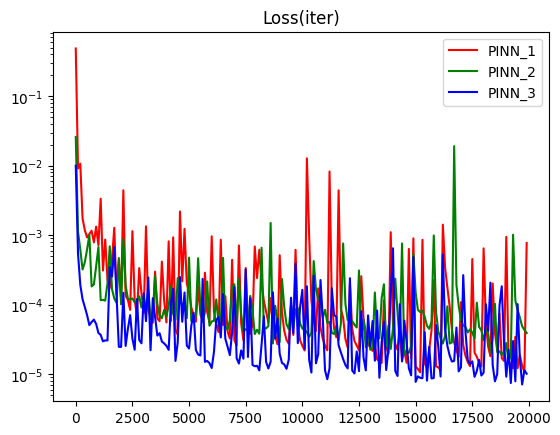

In [6]:
model.train_hist(logscale=True, step=100)

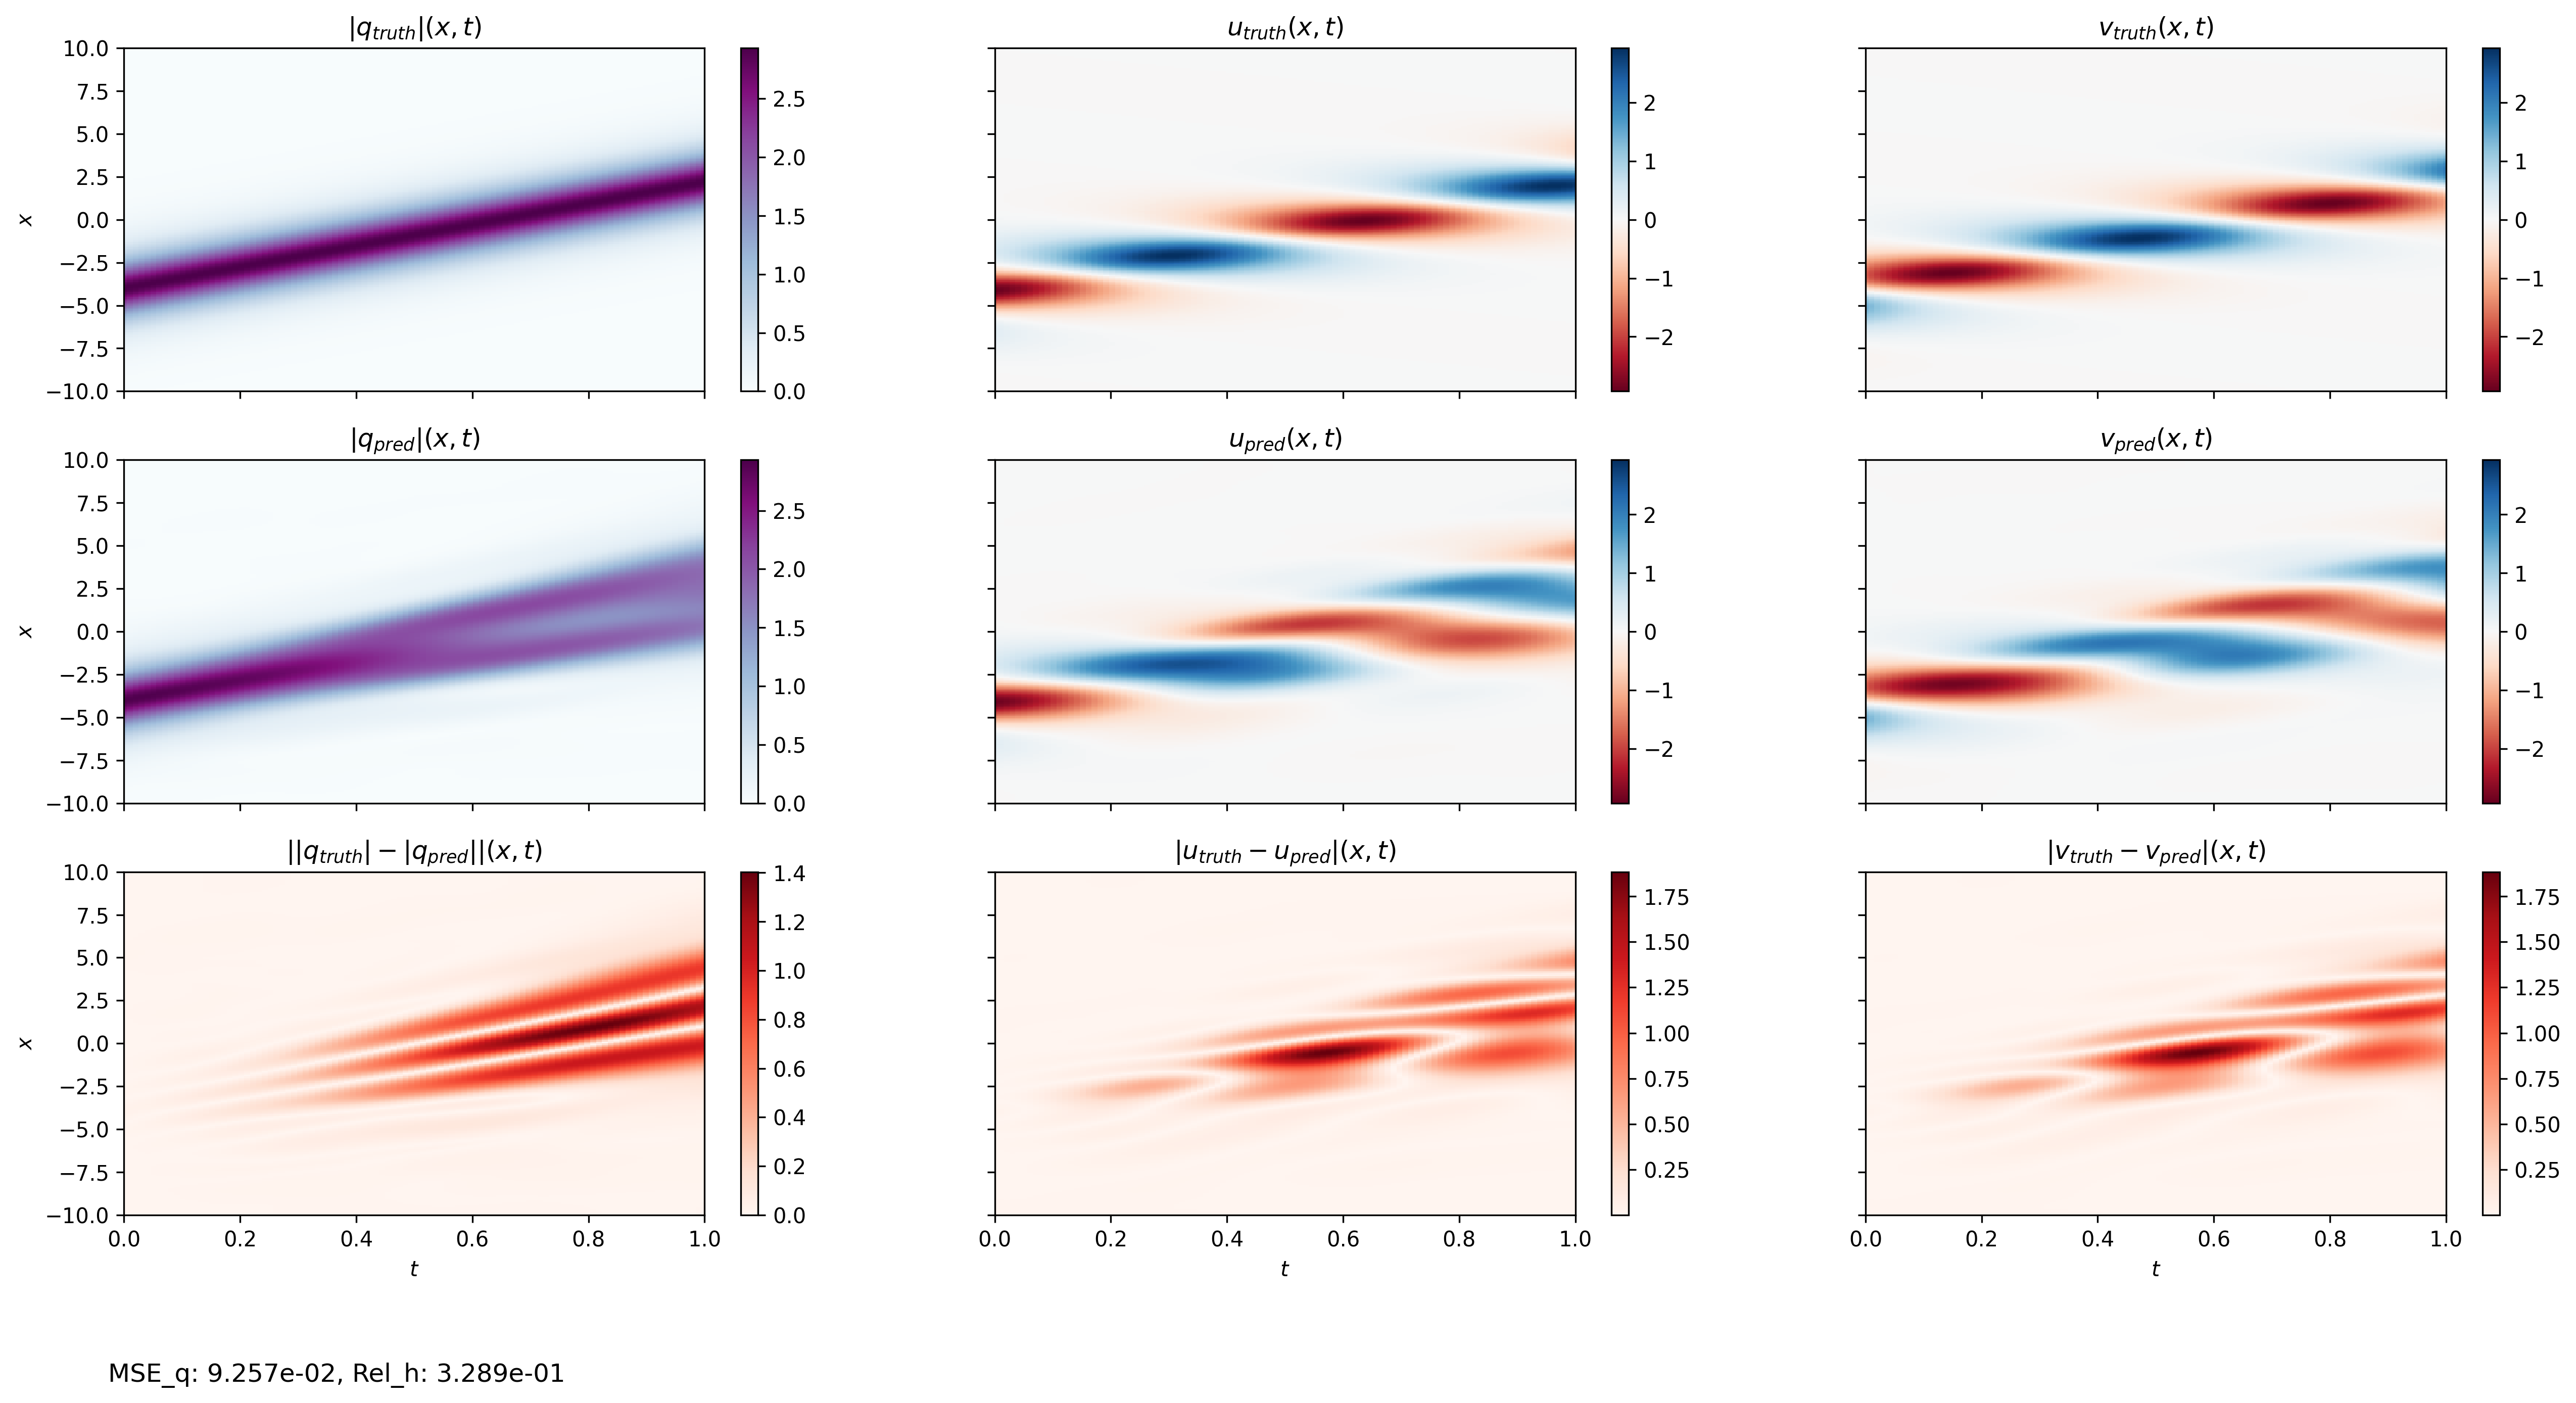

{'MSE_q': 0.09257272295742791, 'Rel_h': 0.32891286320124086}

In [7]:
u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star)
Q_pred=u_pred.reshape((t_parts, x_parts)) + 1j*v_pred.reshape((t_parts, x_parts))
plot_comparison(X, T, Q_pred, Q_truth, savefig=True, namefig="test_comparison(6th_order).png")

Dimensionality by x: 200, by t: 100


{'Lw1_per_max': 2.453413549958805,
 'Lw1_per_mean': 0.9663761565021497,
 'Lw2_per_max': 6.179742398192109,
 'Lw2_per_mean': 3.045307130097807,
 'Rel_h': 0.32891286320124086}

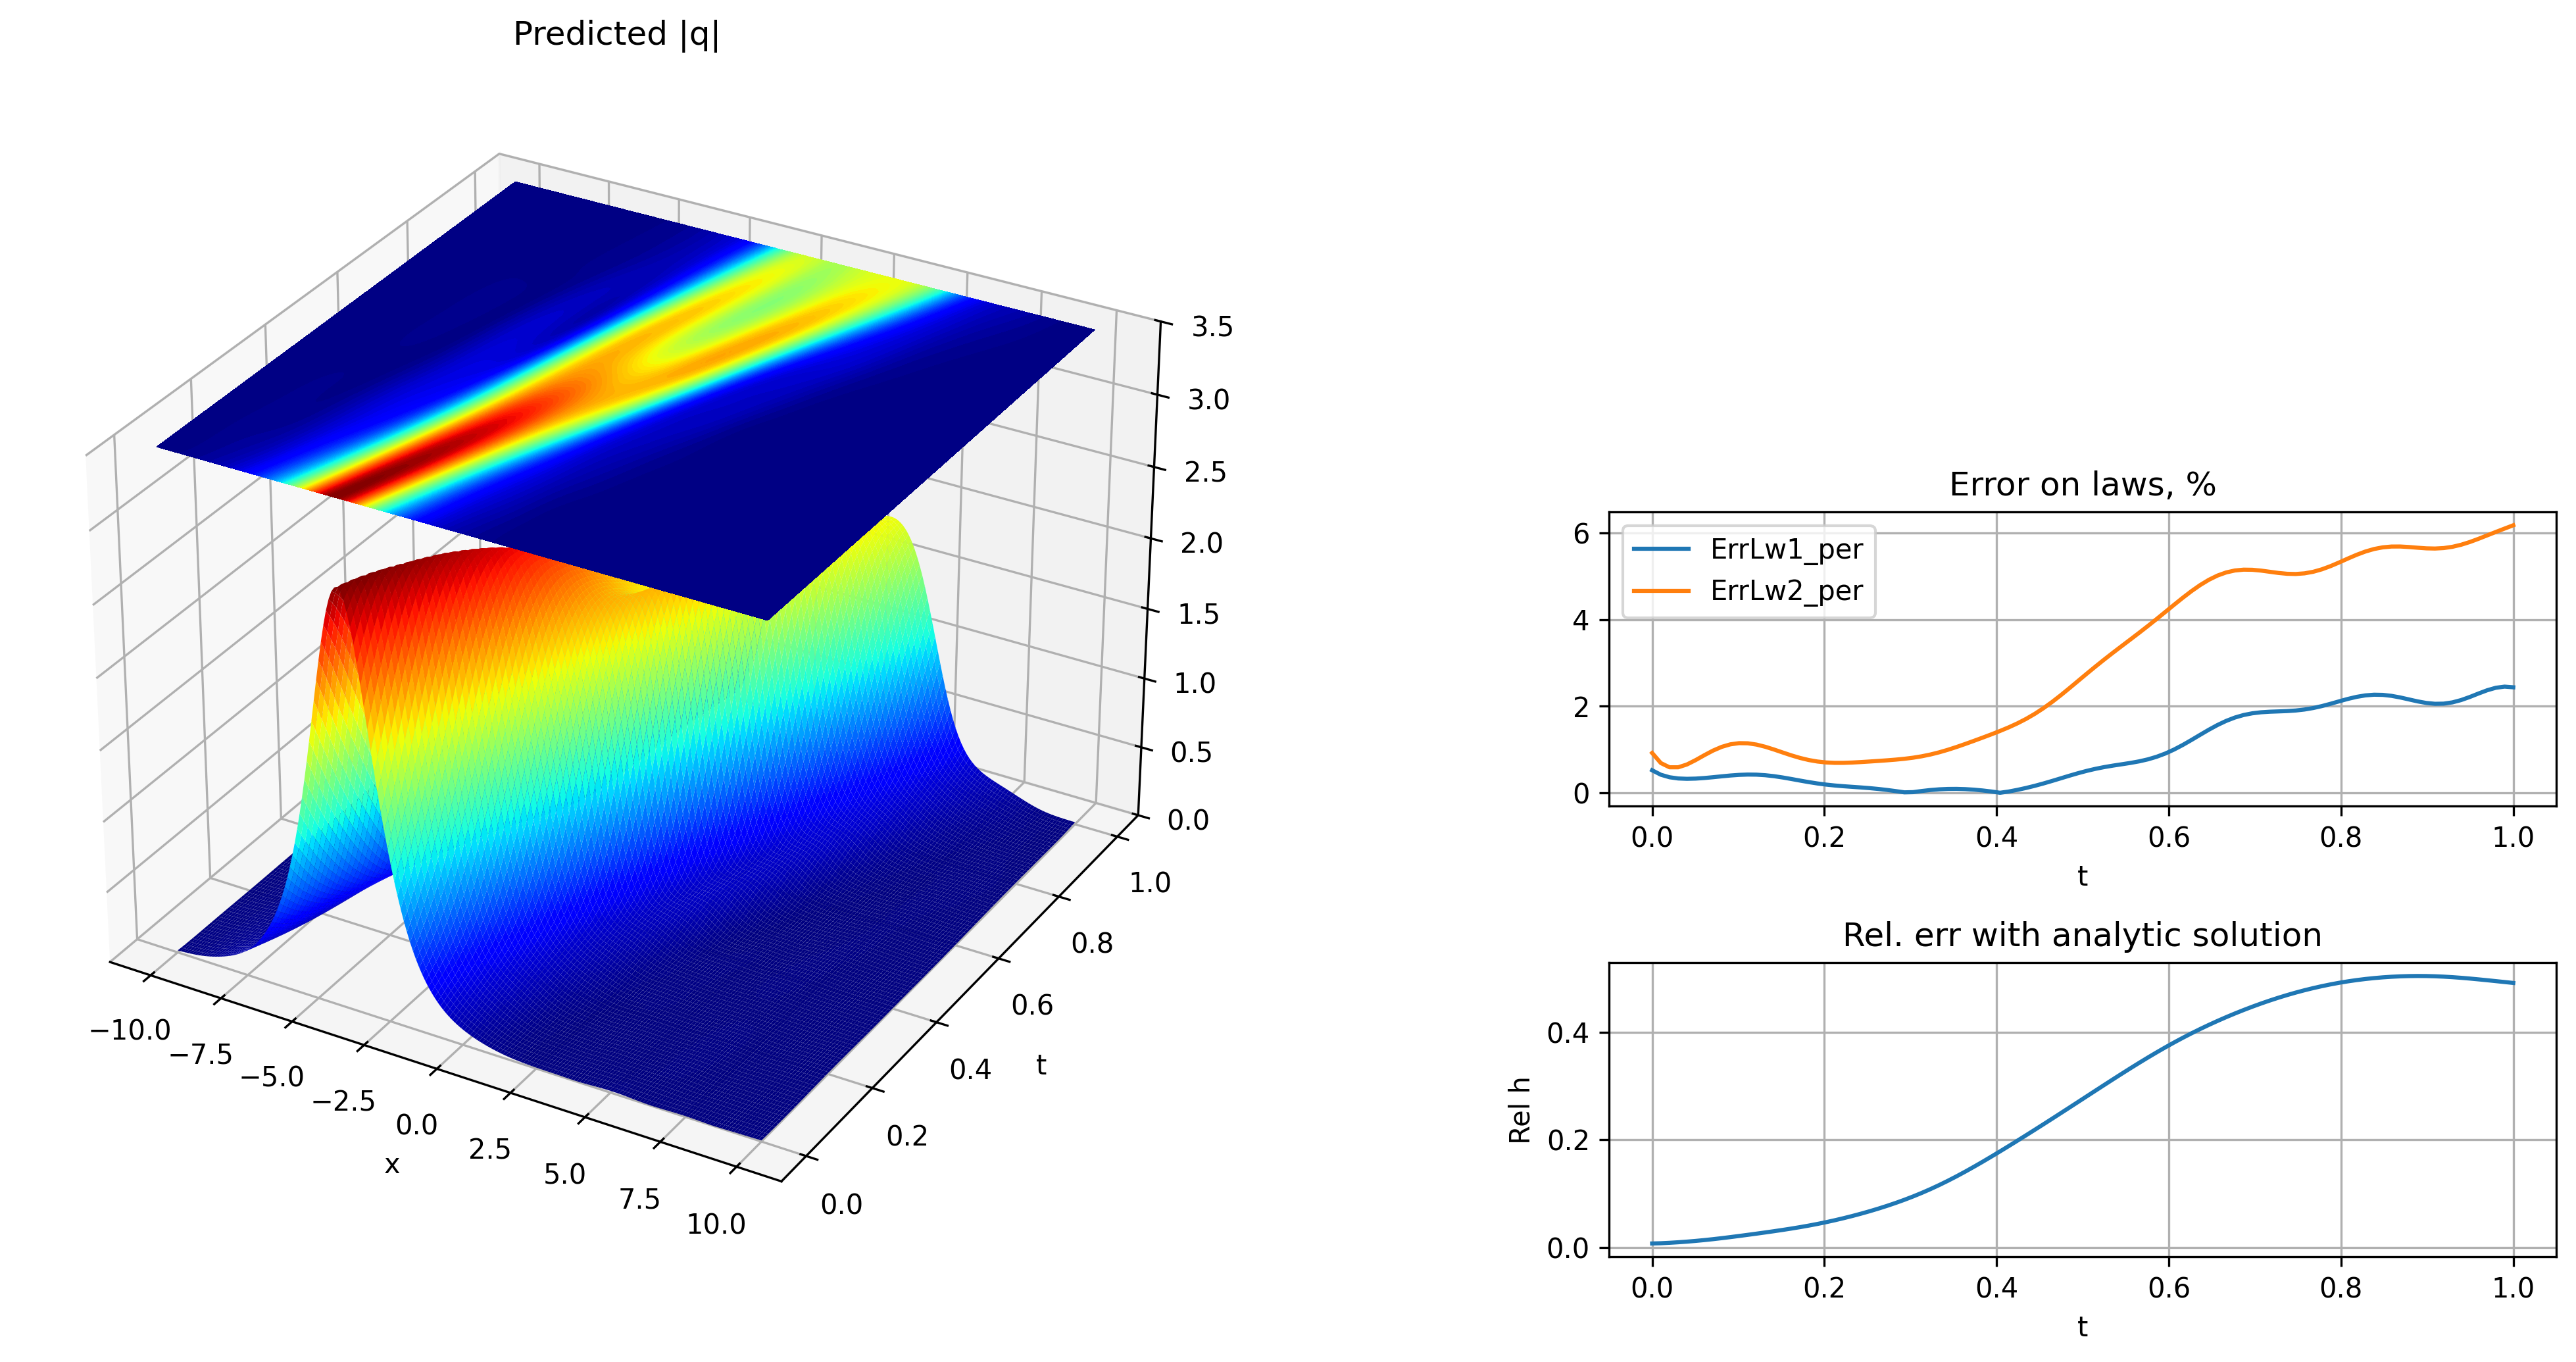

In [8]:
plot_errors(X, T, Q_pred, Q_truth, savefig=True, namefig="test_errors(6th_order).png", savetable=False, nametable="data(6th_order).csv")

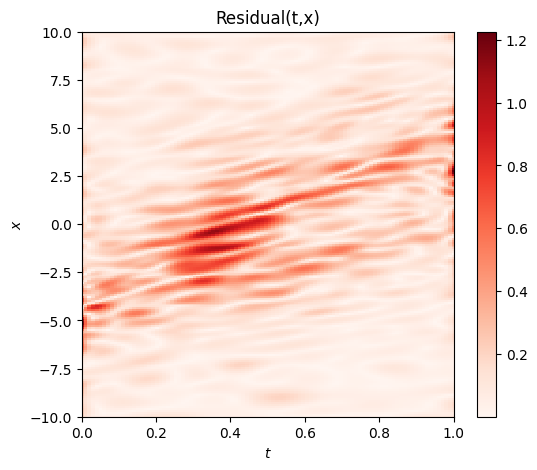

In [9]:
model.plot_residual(X, T)